# Filtering and analysing Singapore-based tweets - exploratory data analysis

### Introduction
**Challenge**: Collecting tweets by ***Singapore-based users*** from streaming Twitter data.

Previous research works relied on relaxed and limited heuristics resulting in noisy data containing false positives of Singapore-based users' tweets. 
This challenging problem is addressed with the help of plausible heuristics to gather Singapore-based users' tweets. 
The data analyses suggest that curated tweets give credible insights about Singapore. 

First, the Twitter streaming data is ingested into MongoDB, data wrangling is performed to curate Singapore-based tweets based on heuristics. 
Exploratory data analysis is then performed on the curated tweets. 

**Factual**: 
- Less than 0.01% of Twitter users will push tweets with their GPS locations.
- Estimated Singapore Twitter Users 1.7M [(Source)](https://www.statista.com/statistics/490600/twitter-users-singapore/#:~:text=Number%20of%20Twitter%20users%20in%20Singapore%202019%2D2021&text=In%202021%2C%20there%20were%20over,between%2025%2D34%20years%20old)
- Tweets grabbed from streaming data will have 0 favorites or retweets, since the tweets are already captured even before others react :D 

Check out the [Twitter streaming API response](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet) for a better understanding of the notebooks. 

### Table of Contents

* 1\. [Heuristics for filtering Singapore-based users' tweets from streaming twitter API](#cell1)
* 2\.     [Loading the data (csv files)](#cell2)
* 3\. [Cleaning and processing the data](#cell3)
    * 3.1. [Datetime cleanup and formatting](#cell31)
    * 3.2. [Geocoding fixes](#cell32)
<!--         * 3.2.1 [Replacing nan with 'Unknown'](#cell321)
        * 3.2.2 [Replacing nan with 'Unknown'](#cell321)
        * 3.2.3 [Replacing nan with 'Unknown'](#cell321)
        * 3.2.4 [Replacing nan with 'Unknown'](#cell321) -->
    * 3.3. [Filtering out non-Singapore accounts - reducing false positives and false negatives](#cell33)
    * 3.4. [Processing the tweets and quoted tweets](#cell34)
* 4\. [Exploratory data analysis of Singapore geo-coded tweets](#cell4) 
    * 4.1. [Basics](#cell41)
    * 4.2. [Sentiment analysis of tweets and quoted tweets](#cell42) 
    * 4.3. [Analysing Singapore users](#cell43)
    * 4.4. [Analysing potentially sensitive tweets (PST) with links](#cell44)
    * 4.5. [Popular hashtags](#cell45)
    * 4.6. [Popular mentions](#cell46)
    * 4.7. [Regional analysis](#cell47)
    * 4.8. [Others](#cell48)

In [1]:
import re
import sys
import os
import time
import glob 
import json
import random
from datetime import datetime  as dt

import collections as col

import numpy as np
import pandas as pd

# import functools as ft
import itertools as it

# visualizations
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# to import the desired function from the module hierarchy
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# 1. Heuristics for filtering Singapore-based users' tweets from streaming twitter API <a id="cell1"></a>

##### Tweets from the streaming twitter API are first ingested into MongoDB. The below heuristics are then applied on the collected tweets to fetch Singapore-based users' tweets:   

**Step 1 -  Collection of potential Singapore-based twitter users:** Users who follow at least 2 of the Singapore based twitter accounts listed below: 

`Singapore based twitter handles
'mindefsg', 'MOEsg', 'sporeMOH', 'LTAsg', 'SMRT_Singapore', 'SBSTransit_Ltd', 'SingaporeHDB', 'MNDSingapore', 'mhasingapore', 'SingaporePolice', 'URAsg',  'MAS_sg', 'MOFsg', 'ICASingapore', 'SingaporeMCI', 'nlbsingapore', 'IMDAsg',  'NEAsg', 'nparksbuzz', 'SGSportsHub', 'govsingapore', 'SingaporeCAAS', 'MFAsg',
 ‘iremembersg', 'youthsg', 'NUSingapore', 'NTUsg', 'sgSMU', 'sutdsg', 'SGRedCross',  'STcom', 'ChannelNewsAsia', 'TODAYonline', 'asiaonecom', 'thenewpaper', 'MothershipSG', 'Singtel', 'StarHub', 'MyRepublicSG', 'M1Singapore', 'temasekpoly', 'singaporetech','SingaporePoly', 'PUBsingapore', 'NgeeAnnNP', 'ITESpore', 'mediacorp', 'YahooSG',  'TimeOutSG', 'VisitSingapore', 'stb_sg', 'GovTechSG', 'SGmagazine', 'mySingapore',  'sgelection', 'SGAG_SG', 'TEDxSingapore', 'STATravelSG', 'STPix'`
 
##### Collected users count: 888739

The file `get_sg_users.py` contains the code for Step 2.

The file `/data/min_2_following_users.txt` contains the list of collected twitter user ids.

**Step 2 - Filtering users' tweets:** Tweets from a user whose:
1. **Twitter user id** in the collected ids as mentioned above OR
2. **Place** is set to Singapore OR
3. **Location** containing `'sg', 'spore', 'singapore', 'singapura'`
4. **Description** containing `'spore', 'singapore', 'singapura'`

The file `get_sg_tweets.py` contains the code for Step 2.

**Step 3 - Filtering tweets with geocoded country as 'Singapore'**


# 2. Loading the data (csv files) <a id="cell2"></a>
##### Loading and merging the fragmented csvs files. The files contain the collected Singapore-based tweets.

In [4]:
DATA_PATH = '../data/'
SG_TWEETS_PATH = 'fragmented_data/tweets_sg/'
SG_TWEETS_ENGAGEMENTS_PATH = 'fragmented_data/tweets_engagements_sg/'

In [5]:
# csvs containing users and tweets specific data
tw_data = pd.concat([pd.read_csv(csv_file, index_col=0, header=0, engine='python') for csv_file in glob.glob(
            os.path.join(DATA_PATH, SG_TWEETS_PATH, "*.csv"))], axis=0, ignore_index=True)

# csvs containing the collected tweets' engagement data - retweets, replies and quoted tweets
tw_eng_data = pd.concat([pd.read_csv(csv_file, index_col=0, header=0, engine='python') for csv_file in glob.glob(
            os.path.join(DATA_PATH, SG_TWEETS_ENGAGEMENTS_PATH, "*.csv"))], axis=0, ignore_index=True)

In [6]:
tw_data.head(5)

tw_data[tw_data['user_geo_tagging'].notna()]['user_geo_tagging'].shape

(12892,)

In [7]:
tw_data.shape

(723023, 19)

In [8]:
12892/723023*100

1.7830691416455633

In [9]:
# list(tw_data[tw_data['user_geo_tagging'].notna()]['user_geo_tagging'])
tw_eng_data.columns

Index(['user_id', 'user_name', 'user_screenname', 'tweet_id',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quoted_user_screenname', 'quoted_user_geo_coding',
       'quoted_user_geo_coding_type', 'quoted_retweet_count',
       'quoted_favorite_count'],
      dtype='object')

In [10]:
tw_eng_data.head(5)

,user_id,user_name,user_screenname,tweet_id,tweet_enagagement_type,replied_to_tweet_id,replied_to_user_id,replied_to_user_screenname,retweeted_tweet_id,retweeted_tweet_time,...,quoted_tweet_id,quoted_tweet_time,quoted_user_id,quoted_user_name,quoted_user_verified,quoted_user_screenname,quoted_user_geo_coding,quoted_user_geo_coding_type,quoted_retweet_count,quoted_favorite_count
0,1.223307e+18,Coronavirus,JayChance12,1423506816089133057,Quote,NaN,NaN,NaN,NaN,NaN,...,1.423391e+18,Thu Aug 05 21:09:49 +0000 2021,1.898686e+08,Tedros Adhanom Ghebreyesus,True,DrTedros,Switzerland|CH,Location,164.0,890.0
1,1.177536e+08,Timbalan Pengarah J-KOM,fakrul07,1423506836423020548,Quote,NaN,NaN,NaN,NaN,NaN,...,1.423460e+18,Fri Aug 06 01:46:11 +0000 2021,1.314752e+08,Dr. Kumar (PSM),False,kumarPsm,NaN,NaN,43.0,112.0
2,2.310111e+09,Journey Home to Singapore,journeyhometosg,1423506851417640960,Quote,NaN,NaN,NaN,NaN,NaN,...,1.423352e+18,Thu Aug 05 18:34:12 +0000 2021,2.313028e+09,Jennifer Zeng 曾錚,False,jenniferatntd,United States|US,Location,33.0,146.0
3,4.560504e+08,Nathalie Gourd,NGourd,1423506861001748482,Quote,NaN,NaN,NaN,NaN,NaN,...,1.423294e+18,Thu Aug 05 14:44:02 +0000 2021,3.839512e+07,franceinfo,True,franceinfo,France|FR,Location,240.0,696.0
4,1.202498e+18,mahisha,corgisha,1423506872175251459,Retweet,NaN,NaN,NaN,1.423205e+18,Thu Aug 05 08:51:15 +0000 2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Inner join of tweets and related engagement data 

In [11]:
tweets_data = tw_data.merge(tw_eng_data, on="tweet_id", how = 'inner')
tweets_data.shape

(429877, 47)

# 3. Cleaning and processing the data <a id="cell3"></a>

In [12]:
tweets_data.columns

Index(['tweet_text', 'tweet_time', 'tweet_id', 'tweet_lang',
       'tweet_possibly_sensitive', 'entity_image_url', 'entity_mentions',
       'entity_hashtags', 'entity_link_url', 'user_id_x', 'user_name_x',
       'user_screenname_x', 'user_friends_count', 'user_followers_count',
       'user_verified', 'user_location', 'user_desc', 'user_geo_coding',
       'user_geo_tagging', 'user_id_y', 'user_name_y', 'user_screenname_y',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quoted_user_scree

In [13]:
tweets_data[tweets_data['entity_image_url'].notna()]['entity_image_url']

9           https://pbs.twimg.com/media/E71g09BVkAQ9wGv.jpg
21          https://pbs.twimg.com/media/E8FPGNyVIAAsIzr.png
27          https://pbs.twimg.com/media/E8CUEqGXsAAwEZ6.jpg
45          https://pbs.twimg.com/media/E8FGnuKXEAEx98L.jpg
57          https://pbs.twimg.com/media/E8FExRBUUAYg2Pn.jpg
                                ...                        
429845      https://pbs.twimg.com/media/CzOfbSnUkAEO2E9.jpg
429853      https://pbs.twimg.com/media/E-91vzUVcAEGEm0.jpg
429855      https://pbs.twimg.com/media/E-92RKhUYAMiyv6.png
429873    https://pbs.twimg.com/ext_tw_video_thumb/14361...
429874    https://pbs.twimg.com/ext_tw_video_thumb/14364...
Name: entity_image_url, Length: 28704, dtype: object

### 3.1. Datetime cleanup and formatting <a id="cell31"></a>

##### Converting to pandas datetime and dropping tweets with improper datetime e.g., string type

In [14]:
tweets_data['tweet_time'] = pd.to_datetime(tweets_data['tweet_time'], errors='coerce')
tweets_data = tweets_data.dropna(subset=['tweet_time'])

##### Adding columns `tweet_datetime` and `tweet_date` for further analyses

In [15]:
tweets_data['tweet_datetime'] = tweets_data.tweet_time.dt.strftime('%Y-%m-%d %H')
tweets_data['tweet_date'] = tweets_data.tweet_time.dt.strftime('%Y-%m-%d')

### 3.2. Geocoding fixes <a id="cell32"></a>

#### What is **geocoding** here? 
Inferring a user's country. 

#### How is geocoding done during data collection?
1. **Coordinate**: If not nullable, latitude, longitude data in 
`coordinates` object are used to fetch the country using the 
[Geocoder library] (https://geocoder.readthedocs.io/), ELSE
2. **Place**: If not nullable, Twitter API provides a user's country in the `place` object, ELSE
3. **User-defined location**: (1) [spaCy](https://github.com/explosion/spaCy) 
to process any place entity in the `location` string (2) Geocoder to fetch the country, ELSE
4. **User-defined description**: (1) [spaCy](https://github.com/explosion/spaCy) 
to process any place entity in the `description` string (2) Geocoder to fetch the country

Tweets that are not geocoded are rejected. 

#### 3.2.1. Replacing nan with 'Unknown' 

In [16]:
tweets_data['quoted_user_geo_coding'].fillna(value='Unknown', inplace=True)
tweets_data['retweeted_user_geo_coding'].fillna(value='Unknown', inplace=True)
tweets_data['user_geo_coding'].fillna(value='Unknown', inplace=True)

##### Visualizing the distribution of geocoded tweets 

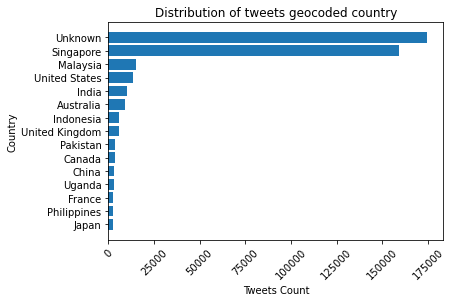

In [17]:
geocoded_tw_data = tweets_data['user_geo_coding']

count_geocoded_tw_data = col.Counter(geocoded_tw_data)
count_geocoded_tw_data = count_geocoded_tw_data.most_common()

# top X countries
TOP_X = 15
countries = [c[0].split('|')[0] for c in count_geocoded_tw_data[:TOP_X]]
counts = [c[1] for c in count_geocoded_tw_data[:TOP_X]]

plt.barh(countries[::-1], counts[::-1])
 
plt.ylabel("Country")
plt.xlabel("Tweets Count")
plt.xticks(rotation=45)
plt.title("Distribution of tweets geocoded country")
plt.show()

#### **Bug fixing**: Users whose location contains a `specific region in Singapore` (e.g., West Singpore, North-east regions) are erroneously coded as `Uganda`

##### Looking for random examples with this error

In [18]:
wrong_geocoded_uganda_users  = list(tweets_data[tweets_data['user_geo_coding'] == 'Uganda|UG']['user_screenname_x'].unique())
for _ in range(5):
    print("https://twitter.com/" + random.choice(wrong_geocoded_uganda_users))

https://twitter.com/thomasquek
https://twitter.com/NrLuqman_
https://twitter.com/syedkhalleff
https://twitter.com/syariqmarican
https://twitter.com/sgbengtwink


In [19]:
print(tweets_data[tweets_data['user_geo_coding'] == 'Uganda|UG']['user_screenname_x'].nunique())
print(tweets_data[tweets_data['quoted_user_geo_coding'] == 'Uganda|UG']['user_screenname_x'].nunique())
print(tweets_data[tweets_data['retweeted_user_geo_coding'] == 'Uganda|UG']['user_screenname_x'].nunique())

641
22
78


#### 3.2.2. Replacing "Uganda|UG" with "Singapore|SG"

In [20]:
tweets_data['user_geo_coding'].replace(['Uganda|UG'], 'Singapore|SG', inplace=True)
tweets_data['retweeted_user_geo_coding'].replace(['Uganda|UG'], 'Singapore|SG', inplace=True)
tweets_data['quoted_user_geo_coding'].replace(['Uganda|UG'], 'Singapore|SG', inplace=True)

#### 3.2.3. Remove the country code from the data (not required)

In [21]:
tweets_data['quoted_user_geo_coding'] = [c.split('|')[0] for c in tweets_data['quoted_user_geo_coding']]
tweets_data['retweeted_user_geo_coding'] = [c.split('|')[0] for c in tweets_data['retweeted_user_geo_coding']]
tweets_data['user_geo_coding'] = [c.split('|')[0] for c in tweets_data['user_geo_coding']]

#### 3.2.4. Fixing **users with multiple geocoded countries**   

TODO: Fix this during data collection with the help of memoization

1. Geocoded countries is ``greater than 2`` 
    - Highly errorneos, set 'Unknown'
2. Geocoded countries count ``is 2`` 
    - If one of the geocodings is 'Unknown' then set the 'other' known location|
    -  If both the geocodings != 'Unknown' then set both to 'Unknown' (dubious case) 

In [22]:
# getting count of users' decoded locations 
# -- TODO what about quoted_user_screenname retweeted_user_screenname
users_geocode_country_count = tweets_data.groupby('user_screenname_x')['user_geo_coding'].nunique().reset_index(name='count')
# users_geocode_country_count[users_geocode_country_count['count'] > 1].sort_values(by='count', ascending=False)

In [23]:
# list of countries with geocoding > 2
users_geocode_country_count_gtr_2 = users_geocode_country_count[users_geocode_country_count['count'] > 2]['user_screenname_x'].unique()

# Setting location to 'Unknown'
tweets_data.loc[tweets_data['user_screenname_x'].isin(users_geocode_country_count_gtr_2), 'user_geo_coding'] = 'Unknown'
tweets_data.loc[tweets_data['user_screenname_x'].isin(users_geocode_country_count_gtr_2), 'retweeted_user_geo_coding'] = 'Unknown'
tweets_data.loc[tweets_data['user_screenname_x'].isin(users_geocode_country_count_gtr_2), 'retweeted_user_geo_coding'] = 'Unknown'

In [24]:
# TODO: Fix this elegantly
users_geocode_country_count_eq_2 = users_geocode_country_count[users_geocode_country_count['count'] == 2]['user_screenname_x']#.unique()
len(users_geocode_country_count_eq_2)

1437

##### Distribution of geo-coded tweets after corrections

In [25]:
geocoded_tw_data = tweets_data['user_geo_coding']

count_geocoded_tw_data = col.Counter(geocoded_tw_data)
count_geocoded_tw_data = count_geocoded_tw_data.most_common()

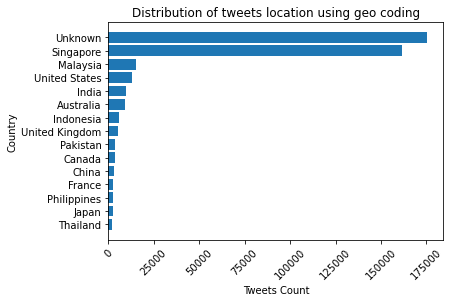

In [26]:
# top X countries
TOP_X = 15
countries = [c[0].split('|')[0] for c in count_geocoded_tw_data[:TOP_X]]
counts = [c[1] for c in count_geocoded_tw_data[:TOP_X]]

plt.barh(countries[::-1], counts[::-1])
 
plt.ylabel("Country")
plt.xlabel("Tweets Count")
plt.xticks(rotation=45)
plt.title("Distribution of tweets location using geo coding")
plt.show()

### 3.3. Filtering out non-Singapore accounts - reducing false positives and false negatives <a id="cell33"></a>

In [27]:
sg_tweets = tweets_data[
                    # 1. geo coded as Singapore
#                     (tweets_data['user_geo_coding'] == 'Unknown') | 
                    (tweets_data['user_geo_coding'] == 'Singapore') | 
                    # 2. user location contains {sg, spore, singapore, singapura}
                    (tweets_data['user_location'].str.contains('sg|spore|singapore|singapura', regex=True, case=False)) |
                    # 3. user description contains {spore, singapore, singapura}
                    (tweets_data['user_desc'].str.contains('spore|singapore|singapura', regex=True, case=False)) |
                     # 4. Quoted tweets by Singaporean and 
                    ((tweets_data['quoted_user_geo_coding'] == 'Singapore') & (tweets_data['user_geo_coding'].isna())) |
                    ((tweets_data['retweeted_user_geo_coding'] == 'Singapore') & (tweets_data['user_geo_coding'].isna()))
            ]
sg_tweets.shape

(181423, 49)

In [28]:
sg_tweets.columns

Index(['tweet_text', 'tweet_time', 'tweet_id', 'tweet_lang',
       'tweet_possibly_sensitive', 'entity_image_url', 'entity_mentions',
       'entity_hashtags', 'entity_link_url', 'user_id_x', 'user_name_x',
       'user_screenname_x', 'user_friends_count', 'user_followers_count',
       'user_verified', 'user_location', 'user_desc', 'user_geo_coding',
       'user_geo_tagging', 'user_id_y', 'user_name_y', 'user_screenname_y',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quoted_user_scree

In [29]:
len(list(sg_tweets[sg_tweets['entity_image_url'].notna()]['entity_image_url']))

13166

### 3.4. Processing the tweets and quoted tweets <a id="cell34"></a>

In [1]:
sg_tweets['tweet_text'] = [txt.replace('&amp;', '&') if isinstance(txt, str) else '' for txt in sg_tweets['tweet_text']]
sg_tweets['quoted_tweet_text'] = [ txt.replace('&amp;', '&') if isinstance(txt, str) else '' for txt in sg_tweets['quoted_tweet_text']]

NameError: name 'sg_tweets' is not defined

##### Processing tweets and quoted tweets

In [31]:
from utils.process_text import TwitterDataProcessing
pre = TwitterDataProcessing()

### 3.5. Predicting sentiment of tweets and quoted tweets <a id="cell35"></a>

In [32]:
processed_tweets = [pre.clean_text(text) for text in sg_tweets['tweet_text']]
sg_tweets['processed_tweet_text'] = processed_tweets

processed_quoted_tweets = [pre.clean_text(text) if isinstance(text, str) == True else '' for text in sg_tweets['quoted_tweet_text']]
sg_tweets['processed_quoted_tweet_text'] = processed_quoted_tweets

##### Adding predicted sentiment for tweets and quoted tweets using off the shelf VADER

Predicting tweets and quoted tweets sentiments

In [33]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
def get_sentiment(doc):
    score = analyzer.polarity_scores(doc)['compound']
    # As per vader's repo : https://github.com/cjhutto/vaderSentiment
    if score >= 0.05:
        sentiment = "positive"
    elif score <= -0.05:

        sentiment = "negative"
    else:
        sentiment = "neutral"
    return sentiment

In [34]:
tw_sentiment = [get_sentiment(text) for text in sg_tweets['processed_tweet_text']]
sg_tweets['tweet_sentiment'] = tw_sentiment

quoted_tw_sentiment = [get_sentiment(text) if text != '' else None for text in sg_tweets['processed_quoted_tweet_text']]
sg_tweets['quoted_tweet_sentiment'] = quoted_tw_sentiment

In [35]:
# df_hashtags_data = pd.DataFrame(data=hashtags_data)
# pd.DataFrame.to_csv(df_sentiments, "data/output/basics/sentiments.csv")

In [36]:
print("---- Duration ---")
print("From {} to {} \n".format(sg_tweets['tweet_date'].min(), sg_tweets['tweet_date'].max()))

print("---- Tweets count---")
print(sg_tweets.shape[0], '\n')

print("---- Attributes---")
sg_tweets.columns

---- Duration ---
From 2021-08-04 to 2021-09-24 

---- Tweets count---
181423 

---- Attributes---


Index(['tweet_text', 'tweet_time', 'tweet_id', 'tweet_lang',
       'tweet_possibly_sensitive', 'entity_image_url', 'entity_mentions',
       'entity_hashtags', 'entity_link_url', 'user_id_x', 'user_name_x',
       'user_screenname_x', 'user_friends_count', 'user_followers_count',
       'user_verified', 'user_location', 'user_desc', 'user_geo_coding',
       'user_geo_tagging', 'user_id_y', 'user_name_y', 'user_screenname_y',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quoted_user_scree

#### Saving the final data with curated sg-tweets for analysis

In [37]:
sg_tweets = sg_tweets.loc[:, ~sg_tweets.columns.str.contains('^Unnamed')]
pd.DataFrame.to_csv(sg_tweets, DATA_PATH + "sg.csv")

## 4. Exploratory data analysis of Singapore geo-coded tweets <a id="cell4"></a>

### 4.1. Basics <a id="cell41"></a>

In [38]:
DATA_PATH = '../data/'

In [39]:
sg_tweets = pd.read_csv(DATA_PATH + "sg.csv")
sg_tweets.shape

(181423, 54)

In [40]:
sg_tweets.shape

(181423, 54)

In [248]:
sg_tweets[sg_tweets['user_geo_tagging'].notna()]['user_geo_tagging'].shape

(5652,)

In [249]:
sg_tweets[sg_tweets['user_geo_tagging'].notna()]['user_geo_tagging'].tolist()[:10]

['PLACE|Central Region, Singapore|Singapore|SG',
 'PLACE|North Region, Singapore|Singapore|SG',
 'LOC|103.856|1.29306',
 'PLACE|Central Region, Singapore|Singapore|SG',
 'LOC|103.96249|1.3342204',
 'LOC|103.78281|1.2880261',
 'PLACE|West Region, Singapore|Singapore|SG',
 'LOC|103.856|1.29306',
 'PLACE|North Carolina, USA|United States|US',
 'LOC|103.84911723|1.33242843']

In [250]:
sg_tweets.columns

Index(['Unnamed: 0', 'tweet_text', 'tweet_time', 'tweet_id', 'tweet_lang',
       'tweet_possibly_sensitive', 'entity_image_url', 'entity_mentions',
       'entity_hashtags', 'entity_link_url', 'user_id_x', 'user_name_x',
       'user_screenname_x', 'user_friends_count', 'user_followers_count',
       'user_verified', 'user_location', 'user_desc', 'user_geo_coding',
       'user_geo_tagging', 'user_id_y', 'user_name_y', 'user_screenname_y',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quo

In [ ]:
sg_tweets_dash = pd.read_csv(DATA_PATH + "sg_tweets_dash.csv")

In [42]:
5652/181423*100

3.1153712594323766

In [43]:
total_tweets = len(sg_tweets)
total_tweets

181423

#### Duration

In [44]:
MAX_DATE = sg_tweets['tweet_date'].max()
MIN_DATE = sg_tweets['tweet_date'].min()
MAX_DATE, MIN_DATE

('2021-09-24', '2021-08-04')

#### Average tweets per day

In [91]:
def generate_dash_daily_tweets(daily_tweets_save_path):
    daily_tweets  = sg_tweets.groupby('tweet_date')['tweet_id'].count().reset_index(name='count')
    avg_tweets = sum(daily_tweets['count'][:-1])/ len(daily_tweets['count'][:-1])
    print(avg_tweets)
    
    pd.DataFrame.to_csv(daily_tweets, daily_tweets_save_path)
    return daily_tweets, avg_tweets

In [92]:
daily_tweets_save_path = DATA_PATH + "output/basics/daily_tweets.csv"
daily_tweets, avg_tweets = generate_dash_daily_tweets(daily_tweets_save_path)

3554.901960784314


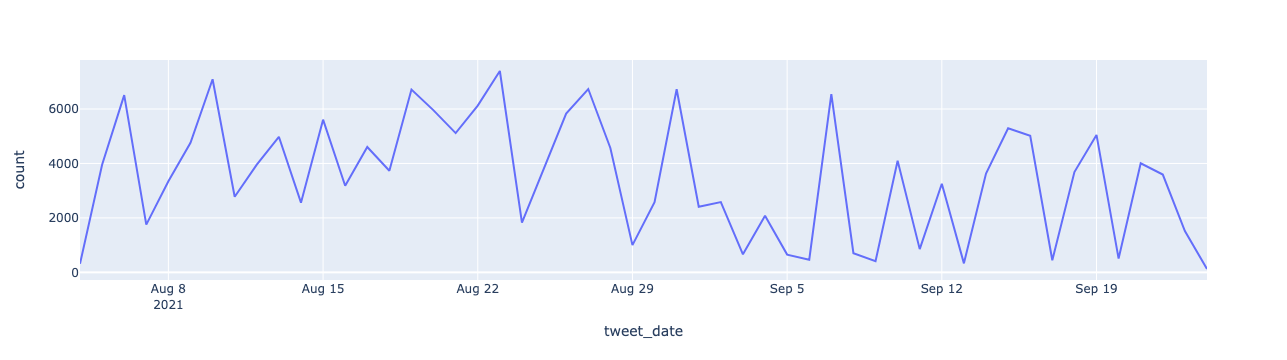

In [93]:
px.line(daily_tweets, x='tweet_date', y='count')

### 4.2. Sentiment analysis of tweets and quoted tweets  <a id="cell42"></a>

##### Distribution of **tweets** sentiments

In [98]:
sg_tweets.columns

Index(['tweet_text', 'tweet_time', 'tweet_id', 'tweet_lang',
       'tweet_possibly_sensitive', 'entity_image_url', 'entity_mentions',
       'entity_hashtags', 'entity_link_url', 'user_id_x', 'user_name_x',
       'user_screenname_x', 'user_friends_count', 'user_followers_count',
       'user_verified', 'user_location', 'user_desc', 'user_geo_coding',
       'user_geo_tagging', 'user_id_y', 'user_name_y', 'user_screenname_y',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quoted_user_scree

In [142]:
MIN_DATE, MAX_DATE

('2021-08-04', '2021-09-24')

In [146]:
df_sentiments = sg_tweets[sg_tweets['tweet_date'].between(MIN_DATE, MAX_DATE, inclusive='both')] \
                .value_counts(subset=['tweet_sentiment']).reset_index(name='count').sort_values(['count'], ascending=False)

fig = px.bar(df_sentiments, x="count", y="tweet_sentiment", orientation='h', template="plotly_white", color="tweet_sentiment")
# fig.show()
df_sentiments

,tweet_sentiment,count
0,neutral,79770
1,positive,57863
2,negative,43790


In [213]:
def generate_dash_sentiments(sentiments_save_path, from_date=MIN_DATE, to_date=MAX_DATE):
    df_sentiments = sg_tweets[sg_tweets['tweet_date'].between(from_date, to_date, inclusive='both')] \
                .value_counts(subset=['tweet_sentiment']).reset_index(name='count').sort_values(['count'], ascending=False)
    pd.DataFrame.to_csv(df_sentiments, sentiments_save_path)
#     return daily_tweets, avg_tweets

In [214]:
sentiments_save_path = DATA_PATH + 'output/basics/sentiments.csv'
generate_dash_sentiments(sentiments_save_path)

##### Distribution of **quoted tweets** sentiments

In [215]:
df_quoted_sentiments = sg_tweets.value_counts(subset=['quoted_tweet_sentiment']).reset_index(name='count').sort_values(['count'], ascending=False)

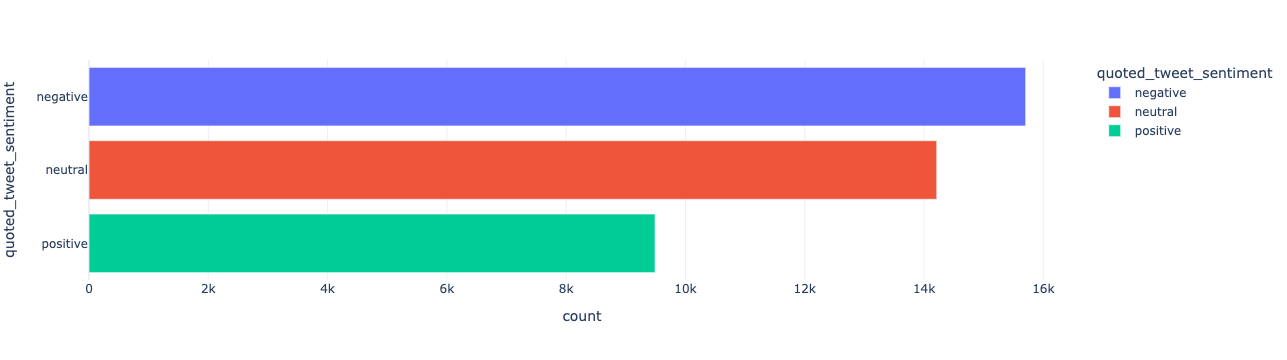

In [216]:
fig = px.bar(df_quoted_sentiments, x="count", y="quoted_tweet_sentiment", orientation='h', template="plotly_white", color="quoted_tweet_sentiment")
fig.show()

##### Reaction on the quoted tweets through sentiment analysis

In [42]:
quoted_tweets_with_sentiment = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Quote') & (sg_tweets['quoted_tweet_sentiment'].notna())]

In [43]:
sentiments = ['positive', 'negative', 'neutral']
sentiments_comb = it.product(sentiments, sentiments)
sentiments_comb = list(sentiments_comb)
sentiments_comb

[('positive', 'positive'),
 ('positive', 'negative'),
 ('positive', 'neutral'),
 ('negative', 'positive'),
 ('negative', 'negative'),
 ('negative', 'neutral'),
 ('neutral', 'positive'),
 ('neutral', 'negative'),
 ('neutral', 'neutral')]

In [44]:
for s1, s2 in sentiments_comb:
#     sc.append('{}_{}'.format(s1, s2))
    print("Tweet: {} | Quoted: {} - {}".format(s1, s2, len(sg_tweets[(sg_tweets['tweet_sentiment'] == s1) &  (sg_tweets['quoted_tweet_sentiment'] == s2)])))

Tweet: positive | Quoted: positive - 3187
Tweet: positive | Quoted: negative - 2444
Tweet: positive | Quoted: neutral - 3341
Tweet: negative | Quoted: positive - 1654
Tweet: negative | Quoted: negative - 4933
Tweet: negative | Quoted: neutral - 2863
Tweet: neutral | Quoted: positive - 4649
Tweet: neutral | Quoted: negative - 8327
Tweet: neutral | Quoted: neutral - 8009


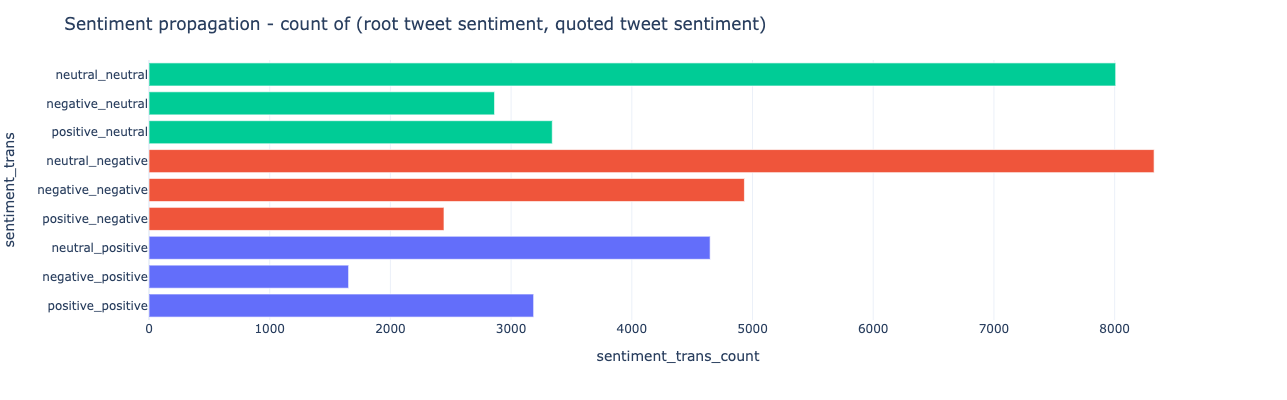

In [45]:
sc = []
sc_count = []
colors = []
for s1, s2 in sentiments_comb:
    sc.append('{}_{}'.format(s1, s2))
    if s2 == 'negative': colors.append('red') 
    elif s2 == 'neutral': colors.append('#FFFF00')
    else: colors.append('green')
    sc_count.append( len(sg_tweets[(sg_tweets['tweet_sentiment'] == s1) &  (sg_tweets['quoted_tweet_sentiment'] == s2)]))
    
sentiment_count = {
    'sentiment_trans': sc,
    'sentiment_trans_count': sc_count
}
sentiment_count

fig = px.bar(sentiment_count, x="sentiment_trans_count", y="sentiment_trans", template='plotly_white', color=colors, 
             height=400)
fig.update_layout(showlegend=False, title="Sentiment propagation - count of (root tweet sentiment, quoted tweet sentiment)")
fig.show()

In [46]:
FROM_SENTIMENT = 'negative'
TO_SENTIMENT = 'positive'

sg_tweets[(sg_tweets["tweet_sentiment"] == FROM_SENTIMENT) & \
          (sg_tweets["quoted_tweet_sentiment"] == TO_SENTIMENT)][['tweet_text', 'quoted_tweet_text']]

,tweet_text,quoted_tweet_text
29,RT @h3yril: shopping malls are so crowded and ...,URA: Safe distancing officers can enter & insp...
113,RT @h3yril: shopping malls are so crowded and ...,URA: Safe distancing officers can enter & insp...
303,#WhatIsHappeningInMyanmar\n#MyanmarCovidSOS \n...,“If the elected civilian government had admini...
306,#WhatIsHappeningInMyanmar\n#MyanmarCovidSOS \n...,“If the elected civilian government had admini...
315,#WhatIsHappeningInMyanmar\n#MyanmarCovidSOS \n...,“If the elected civilian government had admini...
...,...,...
427908,RT @AAhronheim: Seriously??? Are you honestly ...,"When you yearn for freedom, sometimes a spoon ..."
428290,i can think of several other reasons why being...,WATCH:\nUS military walk-outs occurred after B...
428432,RT @KirralieS: The slumber is very deep. I dou...,What is even going on in Australia?\n\nParliam...
429173,RT @indulekshmi16: The fact that they weren’t ...,Up to 500 vaccinated migrant workers a week ca...


### 4.3. Analysing Singapore users  <a id="cell43"></a>

In [47]:
print( "# of unique Singapore users:", sg_tweets['user_id_x'].nunique())
print( "# of verified Singapore users:", sg_tweets[sg_tweets['user_verified'] == True]['user_id_x'].nunique())

# of unique Singapore users: 25922
# of verified Singapore users: 374


In [64]:
# sg_tweets.columns

In [66]:
len(list(sg_tweets['user_screenname_x'].unique()))

22531

In [74]:
sg_tweets[['user_desc', 'user_screenname_x']].head(30)

,user_desc,user_screenname_x
0,Loves traveling. Dislikes the China Communist ...,journeyhometosg
1,um let’s just see how this twitter thing works...,corgisha
2,made dinner for two and I ate both.,tbngrdns
3,👩‍⚕️♏🦂☘️🇲🇲\nWe need R2P in Myanmar.,AhtarSpring
4,she/her,sabjoyy
5,"Singapore Chittappa, Malaysia mama, USA machha",nanumtrackerth1
6,"Don't mind me, I'm just an idea.",jmangulo75
7,ripe with typos until theres an edit button. r...,xyrael
8,Developing cutting-edge security solutions for...,joseph_gan
9,"warm skies, sad eyes",MapleHotcakes


In [234]:
# Saving data for the dashboard
basic_data = {
    'total_tweets': total_tweets,
    'min_date': MIN_DATE,
    'max_date': MAX_DATE,
    'avg_tweets': int(avg_tweets)

}

with open('../data/output/basics/basic.json', 'w') as fp:
    json.dump(basic_data, fp)

#### Users with high number of followers

In [75]:
MIN_FOLLOWERS = 10000
sg_tweets['user_followers_count'] = sg_tweets['user_followers_count'].astype(int)
sg_users_high_followers = sg_tweets[sg_tweets['user_followers_count'] >= MIN_FOLLOWERS].groupby('user_screenname_x') \
[['user_desc', 'user_verified', 'user_followers_count']].nth(0).sort_values(by='user_followers_count', ascending=False)
sg_users_high_followers.head(30)

,user_desc,user_verified,user_followers_count
user_screenname_x,,,
straits_times,Stay in the know with the latest news from Sin...,True,1086547
ChannelNewsAsia,The official space of CNA - the source of brea...,True,1053198
leehsienloong,Prime Minister of Singapore and leader of the ...,True,798436
TODAYonline,Get the latest local and international news fr...,True,692039
zaobaosg,http://zaobao.sg 是新加坡报业控股属下的网站。以第三只眼看大中华，客观新闻和...,False,518588
SoSingaporean,Follow to discover everything so unique and #s...,False,461939
NEAsg,"Also on Facebook https://t.co/xNg9BTncsL, Inst...",True,440894
mrbrown,"mrbrown aka LEE Kin Mun, Blogfather of Singapo...",True,400728
charlesyeo,If you love something use your brain; love som...,False,349669


In [51]:
print("Count of users >= {} followers". format(MIN_FOLLOWERS, len(sg_users_high_followers[sg_users_high_followers['user_verified'] == True])))
print("Count of verified user with {} followers is {}". format(MIN_FOLLOWERS, len(sg_users_high_followers[sg_users_high_followers['user_verified'] == True])))
print("Count of unverified user with {} followers is {}". format(MIN_FOLLOWERS, len(sg_users_high_followers[sg_users_high_followers['user_verified'] == False])))

Count of users >= 10000 followers
Count of verified user with 10000 followers is 136
Count of unverified user with 10000 followers is 288


In [242]:
sg_tweets.columns

Index(['tweet_text', 'tweet_time', 'tweet_id', 'tweet_lang',
       'tweet_possibly_sensitive', 'entity_image_url', 'entity_mentions',
       'entity_hashtags', 'entity_link_url', 'user_id_x', 'user_name_x',
       'user_screenname_x', 'user_friends_count', 'user_followers_count',
       'user_verified', 'user_location', 'user_desc', 'user_geo_coding',
       'user_geo_tagging', 'user_id_y', 'user_name_y', 'user_screenname_y',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quoted_user_scree

### 4.4. Potentially sensitive tweets (PST) with links - marked by twitter <a id="cell44"></a>

In [243]:
def generate_dash_potentially_sensitive_tweets(pst_count_save_path, pst_tweets_save_path, percentile=.95):
    sg_tweets_pst = sg_tweets[sg_tweets['tweet_possibly_sensitive'] == True]

    print("Total possibily sensitive tweets {}".format(len(sg_tweets_pst)))
    print("% possibily sensitive tweets {}".format(len(sg_tweets_pst)/len(sg_tweets)*100))
    
    c_sg_tweets_pst = sg_tweets_pst.value_counts(subset=['tweet_date']).reset_index(name='count') \
                                                .sort_values(['tweet_date'], ascending=False)
    print("Average number of Potentially sensitive tweets: ", sum(c_sg_tweets_pst['count'])/len(c_sg_tweets_pst))
    spike_value = c_sg_tweets_pst['count'].quantile(percentile)
    print("spike_value", spike_value)
#     pst_counts = c_sg_tweets_pst[c_sg_tweets_pst['count'] > spike_value]
    pst_tweets = sg_tweets_pst[['tweet_date', 'processed_tweet_text']]
    
    pd.DataFrame.to_csv(c_sg_tweets_pst, pst_count_save_path)
    pd.DataFrame.to_csv(pst_tweets, pst_tweets_save_path)
    
    

In [244]:
pst_count_save_path = DATA_PATH + "output/basics/pst_counts.csv"
pst_tweets_save_path = DATA_PATH + "output/basics/pst_tweets.csv"

generate_dash_potentially_sensitive_tweets(pst_count_save_path, pst_tweets_save_path)

Total possibily sensitive tweets 9212
% possibily sensitive tweets 5.077636242372797
Average number of Potentially sensitive tweets:  204.7111111111111
spike_value 513.4


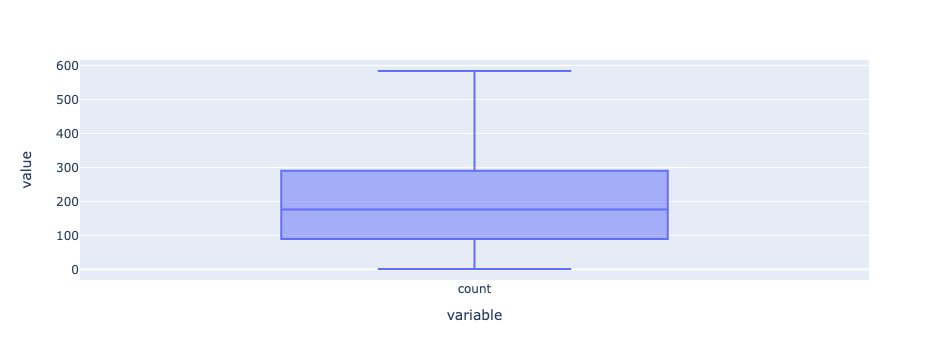

In [245]:
px.box(c_sg_tweets_pst['count'])

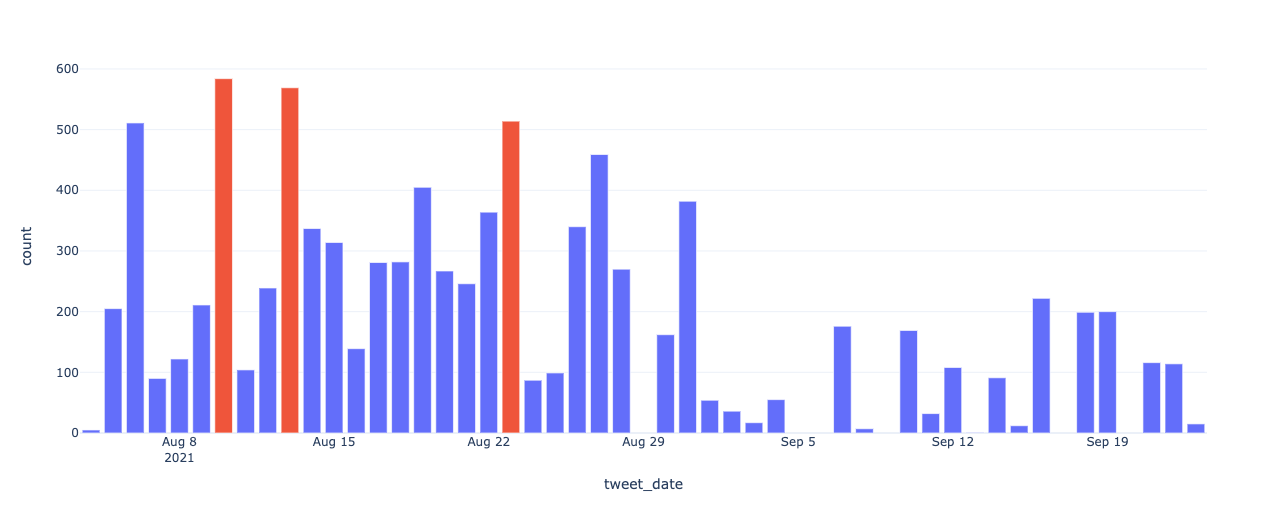

In [235]:
colors = ["red" if cc > spike_value else "green" for cc in c_sg_tweets_pst['count']]
fig = px.bar(c_sg_tweets_pst, x="tweet_date", y="count", template='plotly_white', color=colors,
             height = spike_value)
fig.update_layout(showlegend=False)
fig.show()

In [225]:
# from_d = '2021-08-10'
# to_d = '2021-08-10'

# sg_tweets_pst[sg_tweets_pst['entity_hashtags'].notna() & sg_tweets_pst['tweet_date'].between(from_d, to_d, inclusive='both')]['entity_hashtags'].unique()

In [202]:
sg_tweets[sg_tweets['entity_hashtags'].notna()]['tweet_date'].unique()

array(['2021-08-06', '2021-09-14', '2021-09-15', '2021-08-15',
       '2021-08-16', '2021-08-04', '2021-08-05', '2021-08-10',
       '2021-08-11', '2021-08-07', '2021-09-16', '2021-08-14',
       '2021-08-18', '2021-08-08', '2021-08-09', '2021-08-13',
       '2021-09-11', '2021-09-12', '2021-08-17', '2021-08-12',
       '2021-09-13', '2021-08-24', '2021-08-25', '2021-08-28',
       '2021-08-21', '2021-08-22', '2021-09-23', '2021-09-22',
       '2021-08-23', '2021-08-29', '2021-09-03', '2021-09-04',
       '2021-09-17', '2021-09-18', '2021-09-21', '2021-08-30',
       '2021-09-01', '2021-09-02', '2021-09-24', '2021-09-07',
       '2021-09-08', '2021-09-06', '2021-08-19', '2021-09-19',
       '2021-09-20', '2021-08-31', '2021-08-26', '2021-08-20',
       '2021-08-27', '2021-09-05', '2021-09-09', '2021-09-10'],
      dtype=object)

##### Dates with high PSTs

In [55]:
tweet_date_high_pst = c_sg_tweets_pst[c_sg_tweets_pst['count'] > PST_THRESHOLD]['tweet_date']
list(tweet_date_high_pst)

['2021-08-27',
 '2021-08-23',
 '2021-08-19',
 '2021-08-13',
 '2021-08-10',
 '2021-08-06']

### 4.5.  Popular hashtags <a id="cell45"></a>

In [154]:
def generate_dash_hashtags(hashtags_save_path, from_date=MIN_DATE, to_date=MAX_DATE, top_hash_count=20):
    sg_tweets_hashtags = sg_tweets[sg_tweets['entity_hashtags'].notna() & sg_tweets['tweet_date'].between(from_date, to_date, inclusive='both')]\
                                                                                                          ['entity_hashtags']

    print("Count of tweets with hashtags {}".format(len(sg_tweets_hashtags)))
    print("% of tweets with hashtags {}".format(len(sg_tweets_hashtags)/len(sg_tweets)*100))
    
    hashtags = []

    for h in sg_tweets_hashtags:
        h_list = [hh for hh in h.split('|') if hh not in ['Singapore', 'singapore', 'sg']]
        hashtags.extend(h_list)

    print("Total hashtags:", len(hashtags))
    print("Total unique hashtags:", len(set(hashtags)))
    
    count_hashtags = col.Counter(hashtags).most_common()
    hashtags = [c[0] for c in count_hashtags[:top_hash_count]]
    counts = [c[1] for c in count_hashtags[:top_hash_count]]
    
    plot_hashtags(hashtags, counts)
    
    # Saving data for the dashboard
    hashtags_data = {
        "counts": counts[::-1],
        "hashtag": hashtags[::-1]
    }

    df_hashtags_data = pd.DataFrame(data=hashtags_data)
    pd.DataFrame.to_csv(df_hashtags_data)
    
    
def plot_hashtags(hashtags, counts):
    # count_hashtags
    plt.barh(hashtags[::-1], counts[::-1])

    plt.ylabel("hashtags")
    plt.xlabel("Count")
    plt.xticks(rotation=45)
    plt.title("Distribution of hashtags")
    plt.show()

Count of tweets with hashtags 43083
% of tweets with hashtags 23.747264679781505
Total hashtags: 89848
Total unique hashtags: 12737


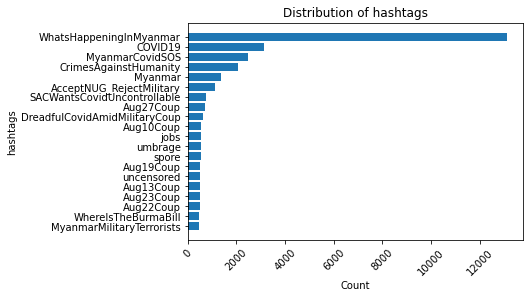

In [155]:
hashtags_save_path = DATA_PATH + "output/basics/hashtags.csv"
generate_dash_hashtags(hashtags_save_path)

### 4.6. Popular mentions <a id="cell46"></a>

In [150]:
def generate_dash_mentions(mentions_save_path, from_date=MIN_DATE, to_date=MAX_DATE, top_mentions_count=20):
    sg_tweets_mentions = sg_tweets[sg_tweets['entity_mentions'].notna() & sg_tweets['tweet_date'].between(from_date, to_date, inclusive='both')] \
                         ['entity_mentions']
    
    print("Count of tweets with mentions {}".format(len(sg_tweets_mentions)))
    print("% tweets with mentions {}".format(len(sg_tweets_mentions)/len(sg_tweets)*100))
    
    mentions = []

    for m in sg_tweets_mentions:
        m_list = [mm for mm in m.split('|')]
        mentions.extend(m_list)

    print("Total mentions:", len(mentions))
    print("Total unique mentions:", len(set(mentions)))
    
    count_mentions = col.Counter(mentions).most_common()

    mentions = [c[0] for c in count_mentions[:top_mentions_count]]
    counts = [c[1] for c in count_mentions[:top_mentions_count]]
    
    plot_mentions(mentions, counts)
    
    # Saving data for the dashboard
    mentions_data = {
        "counts": counts[::-1],
        "mention": mentions[::-1]
    }

    df_mentions_data = pd.DataFrame(data=mentions_data)
    pd.DataFrame.to_csv(df_mentions_data, mentions_save_path)
    
    
def plot_mentions(mentions, counts):
    # count_mentions
    plt.barh(mentions[::-1], counts[::-1])

    plt.ylabel("Screen_name")
    plt.xlabel("Count")
    plt.xticks(rotation=45)
    plt.title("Distribution of mentions")
    plt.show()

Count of tweets with mentions 91955
% tweets with mentions 50.68541474895686
Total mentions: 116606
Total unique mentions: 37576


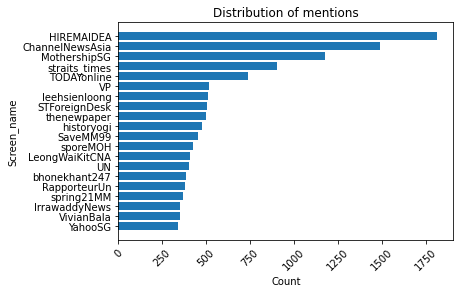

In [151]:
mentions_save_path = DATA_PATH + "output/basics/mentions.csv"
generate_dash_mentions(mentions_save_path)

### 4.7. Regional analysis  <a id="cell47"></a>

Singapore is divided in 5 regions.Checking the distribution of tweets at regional level. 
**Only a subset of tweets is taken containing regional information in the location description**

**Factual**:Population by region:
- **Central Region**	922,580

- **East Region** 685,890

- **North Region** 582,330 

- **North-East Region** 930,910 

- **West Region** 922,540 

In [64]:
tw_user_location_containing_place = list(sg_tweets[sg_tweets['user_geo_tagging'].str.contains('PLACE', na=False, regex=True)]['user_geo_tagging'])
len(tw_user_location_containing_place)

2471

In [65]:
print("Number of tweets from Central: ", sum('Central' in s for s in tw_user_location_containing_place))
print("Number of tweets from West: ", sum('West' in s for s in tw_user_location_containing_place))
print("Number of tweets from East: ", sum('East ' in s for s in tw_user_location_containing_place))
print("Number of tweets from North-East: ", sum('North-East' in s for s in tw_user_location_containing_place))
print("Number of tweets from North: ", sum('North ' in s for s in tw_user_location_containing_place))
print("-"*10)
print("% of tweets from Central: ", sum('Central' in s for s in tw_user_location_containing_place)/len(tw_user_location_containing_place)*100)
print("% of tweets from West: ", sum('West' in s for s in tw_user_location_containing_place)/len(tw_user_location_containing_place)*100)
print("% of tweets from North-East: ", sum('North-East' in s for s in tw_user_location_containing_place)/len(tw_user_location_containing_place)*100)
print("% of tweets from North: ", sum('North ' in s for s in tw_user_location_containing_place)/len(tw_user_location_containing_place)*100)
print("% of tweets from East: ", sum('East ' in s for s in tw_user_location_containing_place)/len(tw_user_location_containing_place)*100)

Number of tweets from Central:  757
Number of tweets from West:  298
Number of tweets from East:  571
Number of tweets from North-East:  371
Number of tweets from North:  133
----------
% of tweets from Central:  30.63537029542695
% of tweets from West:  12.059894779441521
% of tweets from North-East:  15.01416430594901
% of tweets from North:  5.382436260623229
% of tweets from East:  23.108053419668153


### 4.8. Others <a id="cell48"></a>

#### Fake news

In [66]:
fake_news_sources = []
with open("../data/fake_news_sources.txt", 'r') as f:
    for line in f:
        fake_news_sources.append(line.strip('\n'))

fake_news_sources_reg = '|'.join(fake_news_sources)

In [67]:
len(fake_news_sources)

998

In [68]:
sg_fake_news = sg_tweets[sg_tweets['entity_link_url'].str.lower().str.contains(fake_news_sources_reg, na=False, regex=True, case=False)]

In [69]:
sg_fake_news

,tweet_text,tweet_time,tweet_id,tweet_lang,tweet_possibly_sensitive,entity_image_url,entity_mentions,entity_hashtags,entity_link_url,user_id_x,...,quoted_user_geo_coding,quoted_user_geo_coding_type,quoted_retweet_count,quoted_favorite_count,tweet_datetime,tweet_date,processed_tweet_text,processed_quoted_tweet_text,tweet_sentiment,quoted_tweet_sentiment


#### Images shared on twitter 

In [70]:
imgs_sg_tweets = sg_tweets[(sg_tweets['entity_image_url'].notna())]
imgs_sg_tweets['entity_image_url']

9         https://pbs.twimg.com/media/E71g09BVkAQ9wGv.jpg
21        https://pbs.twimg.com/media/E8FPGNyVIAAsIzr.png
27        https://pbs.twimg.com/media/E8CUEqGXsAAwEZ6.jpg
57        https://pbs.twimg.com/media/E8FExRBUUAYg2Pn.jpg
65        https://pbs.twimg.com/media/E8BVOYcVgAIH4_j.png
                               ...                       
429548    https://pbs.twimg.com/media/E-9VwiGUcAA-lDW.jpg
429713    https://pbs.twimg.com/media/E-6cVEUVIAA-tKw.jpg
429748    https://pbs.twimg.com/media/E-7oiBSVUAMZvgH.jpg
429777    https://pbs.twimg.com/media/E-90ZjPXEC8zY81.jpg
429825    https://pbs.twimg.com/media/E-lvmKhXIAcsDYw.jpg
Name: entity_image_url, Length: 13166, dtype: object

#### Listing tweets with random hate words

In [71]:
hate_sg_tweets = sg_tweets[(sg_tweets['tweet_text'].str.contains('racism|racist|xeno', case=False, regex=True))]
hate_sg_tweets.shape

(268, 53)

In [72]:
list(hate_sg_tweets['tweet_text'])[:10]

['RT @fuhduhduhh: imagine seeing chinese singaporeans being racist and thinking "how far singapore has fallen without lky\'s authority"',
 'No but wait what do you mean racism doesn’t exist in Singapore? I don’t care if you haven’t faced it bro I’ve known… https://t.co/Qgv6JpNCcX',
 '@PeterFl13201217 @Inseer_ @Dominic2306 Do you think Singapore is not xenophobic. \n\nSingapore is far more xenophobic… https://t.co/P5ABrH4GiE',
 'Tik Tok series: Racism in Singapore\nEP 3: What is your view on xenophobia in Singapore?\n\nWatch here: https://t.co/M49Ui7Ns2A',
 "Well won't this be very interesting. Covid safety & health vs the 'racism' debate. Quite the conundrum and a true t… https://t.co/GXHWi74aBz",
 'RT @sara_sailesh: Racism in Singapore against Indians are so bad that I worry for my children in the future . \n\nSuch a small country but so…',
 '@BahrSinan @Xeno_Imperial @MegaManMain @DudespostingWs Probably holiday... there was soccer events in Singapore but… https://t.co/SSVWE2fQKb',
 

#### Local news Singapore reporters 

In [73]:
sg_tweets[sg_tweets['user_screenname_x'].isin(['stompsingapore'])]['tweet_text']

13989     "To my shock and disbelief, an animal that I h...
32831     The Singaporean father is accused of four coun...
115130    "Despite the pandemic and struggles by some st...
298814    If you have any information regarding the inci...
301049    “Her blatant disregard for the law and selfish...
315649    Preliminary investigations revealed that the u...
Name: tweet_text, dtype: object

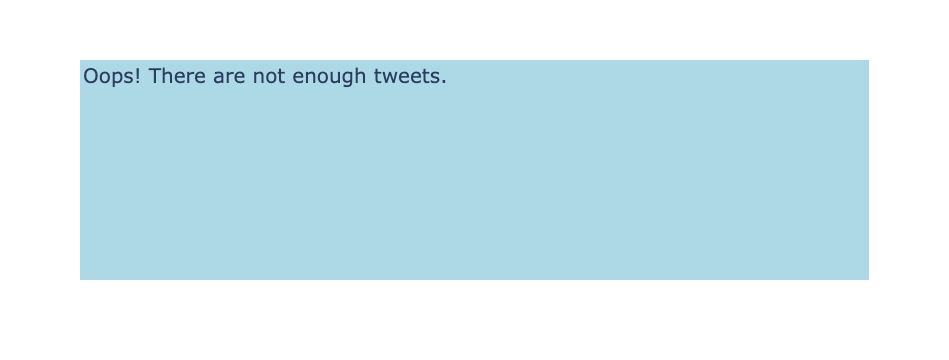

In [25]:
MARGIN = 100
import plotly.express as px
fig = px.treemap(
    names = ["Oops! There are not enough tweets."],
    parents = ["",]
)
fig.update_traces(root_color="lightblue")
fig.update_layout(font=dict(
                           family="Verdana, monospace",
                           size=20
                       ),)